In [102]:
import pandas as pd  ;  import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,  \
QuantileTransformer, PowerTransformer, Normalizer
from sklearn.metrics import precision_score, recall_score, roc_auc_score

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance # 중요변수 시각화
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # model 평가
import pandas as pd
import xgboost

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [103]:
# 데이터 불러오기
df = pd.read_csv('chb_butter_filter_train.csv')

In [148]:
for i in df.uid.unique():

    df.loc[df.uid==i] = df[df.uid==i][:3200]
    df = df[df.uid.notnull()]
df = df[['uid','hbt_1','hbt_2','hbt_3','hbt_4','hbt_5','hbt_6','hbt_7','label']]
df.insert(8,'hbt-mean',df[['hbt_1','hbt_2','hbt_3','hbt_4','hbt_5','hbt_6','hbt_7']].T.mean())

df.loc[df.label== 'AD', 'label'] = 1
df.loc[df.label== 'CN', 'label'] = 0 # 추가한것
df.loc[df.label== 'MCI', 'label'] = 1 # 추가한것
df['label'] = df['label'].astype(int)

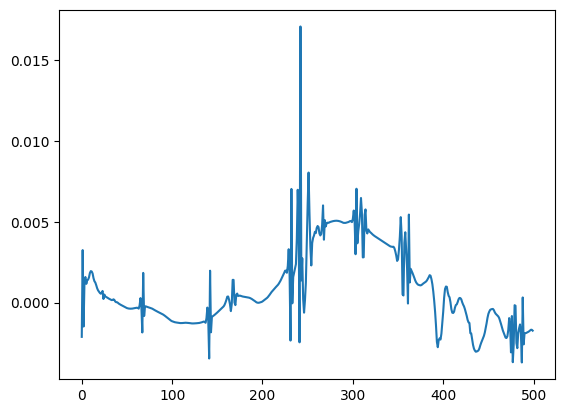

In [149]:
train   = df.copy()

feature = 'hbt-mean'

time_seq = 3200
train_user_num = len(train.uid.unique())  # 학습 데이터 수
x_train_hbo = np.array(train[feature].values).reshape(train_user_num, time_seq) # 넘파이 변환
y_train = np.array(train.drop_duplicates(['uid']).label.values)

plt.plot(x_train_hbo[0][:500])

In [150]:
# scaler = QuantileTransformer(output_distribution='normal')
# scaler = RobustScaler()
scaler = StandardScaler()



x_train_hbo = scaler.fit_transform(x_train_hbo)   # 스케일링 학습 데이터 적용

In [151]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_hbo, y_train, 
                                                      test_size=0.15, 
                                                      shuffle=True, 
                                                      stratify=y_train, 
                                                      random_state=42)

In [152]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((83, 3200), (15, 3200), (83,), (15,))

In [153]:
# XGBmodel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# history = XGBmodel.fit(x_train, y_train)

In [154]:
model_1 = LogisticRegression(solver='liblinear', random_state=42)
model_2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',random_state=42)
model_3 = RandomForestClassifier(n_estimators=1000,random_state=42)
model_1.fit(x_train, y_train)
model_2.fit(x_train, y_train)
model_3.fit(x_train, y_train)

C:\Users\USER\anaconda3\envs\main\lib\site-packages\xgboost\core.py:158: UserWarning: [19:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomForestClassifier(n_estimators=1000, random_state=42)

In [155]:
model = (model_1.predict_proba(x_train)/3 +
         model_2.predict_proba(x_train)/3 +
         model_3.predict_proba(x_train)/3)

In [156]:
final_model = VotingClassifier(
    estimators=[('lr', model_1), ('xgb', model_2), ('rf', model_3)], voting='hard')

In [157]:
final_model.fit(x_train, y_train)

C:\Users\USER\anaconda3\envs\main\lib\site-packages\xgboost\core.py:158: UserWarning: [19:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_polic...
                                            learning_rate=None, max_bin=None,
                  

In [158]:
print('앙상블 model - train 정확도 : {:.3f}'.format(final_model.score(x_train, y_train)))
print('앙상블 model - test 정확도 : {:.3f}'.format(final_model.score(x_valid, y_valid)))
print('앙상블 model - test 정밀도 : {:.3f}'.format(precision_score(y_valid, final_model.predict(x_valid),average= "macro") ))
print('앙상블 model - test 재현율 : {:.3f}'.format(recall_score(y_valid, final_model.predict(x_valid),average= "macro") ))

앙상블 model - train 정확도 : 1.000
앙상블 model - test 정확도 : 0.667
앙상블 model - test 정밀도 : 0.693
앙상블 model - test 재현율 : 0.652
